# Phase 2 - Behavioral Economics of Vaccination 

## Game-Theoretic Decision-Making for Vaccination

This notebook introduces and explores:
1. **Utility Functions**: Calculating the perceived risks of vaccination choice, and the **decision rule** governing the ultimate choice
2. **Behavioral Feedback Loop**: Exploring the dynamic relationship between disease prevalence and vaccination choice
3. **Nash vs. Utilitarian Strategies**: Finding the balance between individual self-interest and maximizing social welfare

In [44]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import sys, os 
sys.path.append(os.path.abspath(os.path.join("..","src")))

from epimodels.behavioral_model import BehavioralParameters, BehavioralDecisionModel
from dataio.seirv_parameters import MeaslesParameters

%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Model Setup and Baseline Parameters

In [45]:
# epidemiological parameters
epi_params = MeaslesParameters()

# behavioral parameters
behavioral_params = BehavioralParameters(
    # vaccine perception
    vaccine_perceived_cost=46.0,             # direct cost
    vaccine_perceived_risk=0.0001,           # very low adverse event risk   
    vaccine_perceived_severity=1000.0,       # perceived cost if adverse event

    # disease perception
    disease_perceived_severity=50000.0,      # much worse than vaccine adverse event

    # WHO 3 C's
    confidence=0.9,                          # high confidence in vaccines
    complacency_threshold=0.001,             # below 0.1% prevalence -> complacent
    complacency_strength=0.5,                # moderate complacency effect
    convenience_factor=1.0,                  # easy access 

    # risk perception
    risk_perception_bias=1.0                 # accurate perception (baseline)
)

# create decision model
decision_model = BehavioralDecisionModel(behavioral_params)

print("parameters loaded successfully")
print(f"R0 = {epi_params.R0}")
print(f"Herd Immunity Threshold = {1 - 1/epi_params.R0:.1%}")

parameters loaded successfully
R0 = 15.0
Herd Immunity Threshold = 93.3%


## Core Mechanics: Utility Functions

How do utilities change with disease prevelance? 

In [46]:
# test utilities change at different prevalence levels?
prevalence_levels = [0.0001, 0.001, 0.01, 0.05, 0.1]    # 0.1% - 10%
coverage = 0.7      # assume 70% vaccinated 

print("Utility Comparison Across Prevalence Levels")
print(f"{'Prevalence':<12}  {'U(vax)':<12}  {'U(no vax)':<12}   {'Decision':<15}")

for prev in prevalence_levels:
    u_vax = decision_model.utility_vaccinate()
    u_no_vax = decision_model.utility_no_vaccinate(prev, coverage, epi_params.R0)

    decision = "Vaccinate" if u_vax > u_no_vax else "Don't Vaccinate" 
    print(f"{prev*100:>6.2f}%       ${u_vax:>8.0f}      ${u_no_vax:>8.0f}       {decision}")


Utility Comparison Across Prevalence Levels
Prevalence    U(vax)        U(no vax)      Decision       
  0.01%       $     -46      $      -0       Don't Vaccinate
  0.10%       $     -46      $      -3       Don't Vaccinate
  1.00%       $     -46      $     -30       Don't Vaccinate
  5.00%       $     -46      $    -152       Vaccinate
 10.00%       $     -46      $    -305       Vaccinate


As prevalence increases, U(no vax) becomes more negative. Higher expected disease costs make vaccination more attractive. 

## Vaccination Probability: How decisions respond to prevalence

Let's look at how vaccination probability responds to prevalence

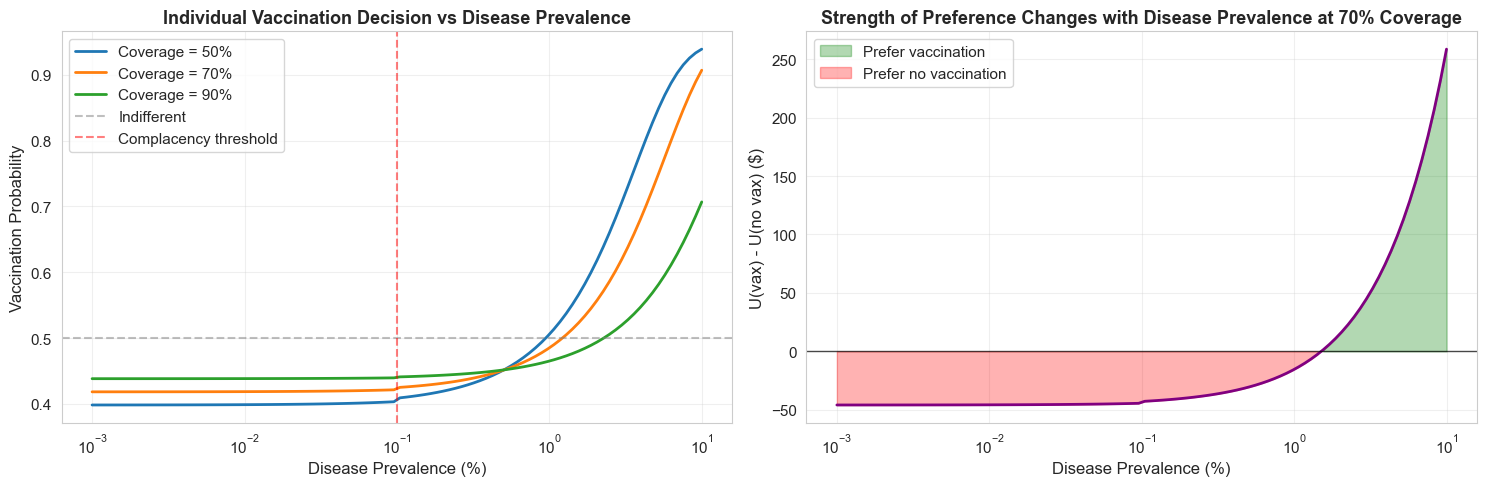

In [47]:
prevalences = np.logspace(-5, -1, 100)  # 0.001% to 10%
coverage_levels = [0.5, 0.7, 0.9]       # different baseline coverage

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Vaccination probability vs prevalence
for cov in coverage_levels:
    vax_probs = [decision_model.vaccination_probability(p, cov, epi_params.R0) 
                 for p in prevalences]
    ax1.plot(prevalences * 100, vax_probs, label=f'Coverage = {cov:.0%}', linewidth=2)

ax1.set_xscale('log')
ax1.set_xlabel('Disease Prevalence (%)', fontsize=12)
ax1.set_ylabel('Vaccination Probability', fontsize=12)
ax1.set_title('Individual Vaccination Decision vs Disease Prevalence', 
              fontsize=13, fontweight='bold')
ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Indifferent')
ax1.axvline(x=0.1, color='red', linestyle='--', alpha=0.5, label='Complacency threshold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Utility difference (shows decision clarity)
utility_diffs = []
for p in prevalences:
    u_vax = decision_model.utility_vaccinate()
    u_no_vax = decision_model.utility_no_vaccinate(p, 0.7, epi_params.R0)
    utility_diffs.append(u_vax - u_no_vax)

ax2.plot(prevalences * 100, utility_diffs, linewidth=2, color='purple')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.7, linewidth=1)
ax2.fill_between(prevalences * 100, 0, utility_diffs, 
                  where=np.array(utility_diffs)>0, alpha=0.3, color='green', 
                  label='Prefer vaccination')
ax2.fill_between(prevalences * 100, 0, utility_diffs, 
                  where=np.array(utility_diffs)<0, alpha=0.3, color='red',
                  label='Prefer no vaccination')
ax2.set_xscale('log')
ax2.set_xlabel('Disease Prevalence (%)', fontsize=12)
ax2.set_ylabel('U(vax) - U(no vax) ($)', fontsize=12)
ax2.set_title('Strength of Preference Changes with Disease Prevalence at 70% Coverage', 
              fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The above plots demonstrate the expected changing attitudes toward vaccination as coverage and disease prevalence change. 

In the left plot - "Indivual Vaccination Decision vs. Disease Prevalence" - I'm looking at how likely an unvaccinated person is to choose vaccination when coverage levels are low (Blue), medium (Orange) or high (Green). The plot demonstrates several key effects:
- **Free Rider Effect**: When fewer ar vaccinated (Blue) you get higher individual risk and more incentive to vaccinate as prevalence spreads, hence the sharper turn in trajectory. Alternatively, when many are vaccinated (Green) free-riders are protected by herd immunity, and only when prevalence is high do individuals cross that indifference threshold. 
- **Prevalence Response**: The curves take a while to really shoot up. This makes sense - when disease is rare, changing your vaccination status feels less urgent but when it is common the incentive to get vaccinated is strong. 
- **Complacency Threshold**: There is a slight but visible kink in our solid lines at the complacency threshold, this is because below this threshold complacency reduces perceived risk. 
- **Coverage Stratification**: The three distinct solid curves demonstrate how societal coverage affects individual decisions.

In the right plot - "Strength of Preference Changes with Disease Prevalence at 70% Coverage" - I've set the societal coverage to 70% and we get a closer look at how disease prevalence and financial concerns affect vaccination choice behavior. 
- **Zero-Crossing**: The financial decision to get vaccinated crosses zero, meaning it is now more cost-effective to get vaccinated than to remain unvaccinated when disease prevalence is around 1-2%. 
- **Reasonable Magnitude**: The "cost" of vaccination (~$46) is outweighed by the perceived cost of remaining unvaccinated as disease spreads. 


## WHO 3 C's Framework: Parameter Sensitivity

Now I'll explore how Confidence, Complacency, and Convenience affect decisions.

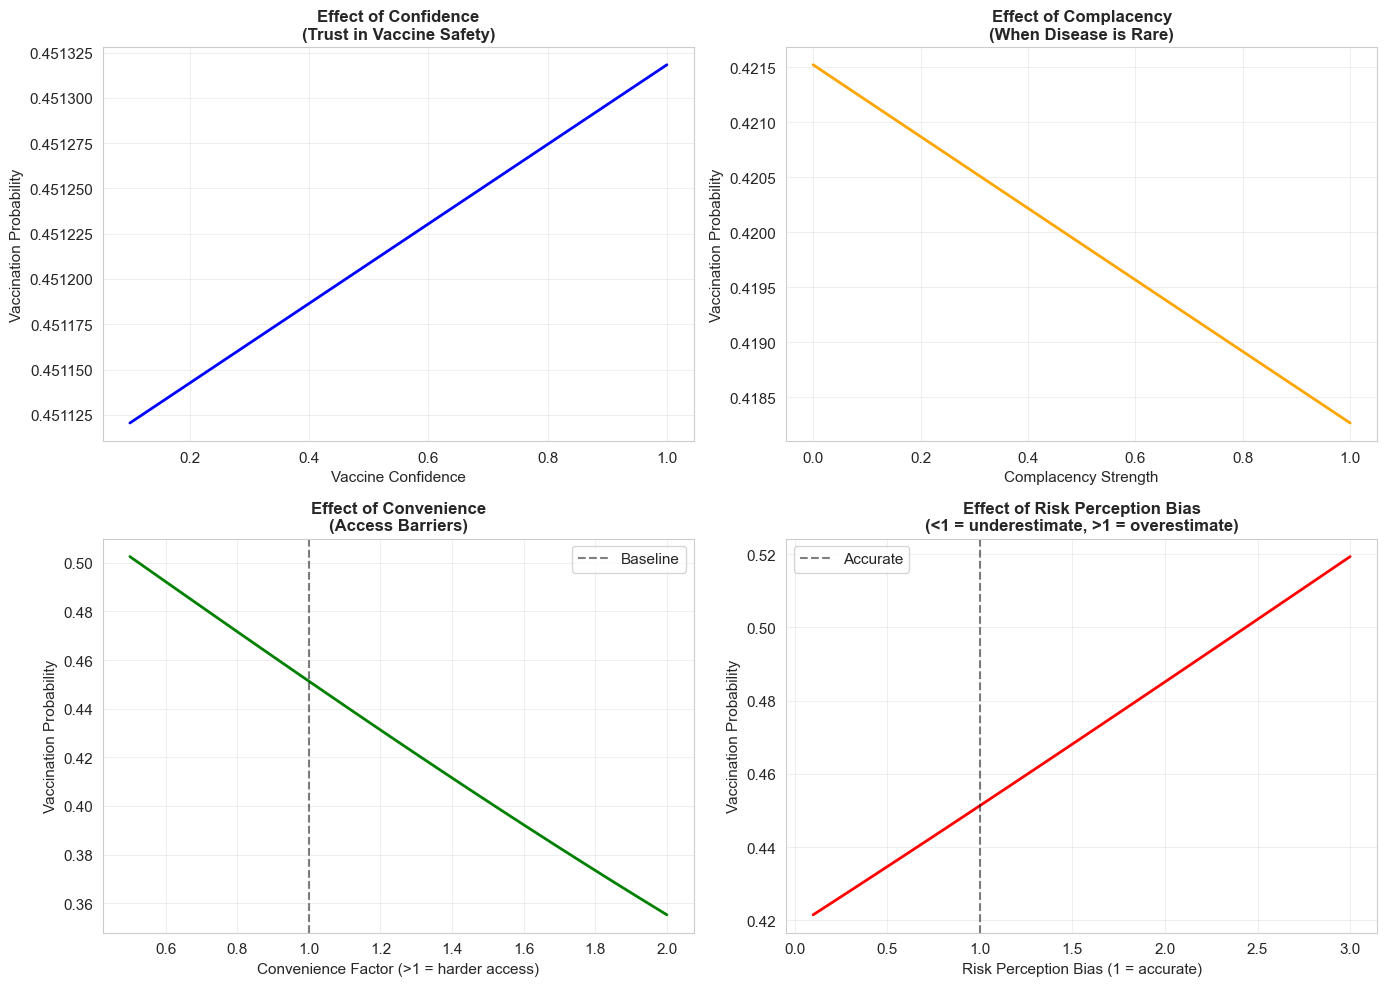

In [48]:
# fixed scenario
test_prevalence = 0.005  # 0.5% prevalence
test_coverage = 0.7

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Confidence effect
ax = axes[0, 0]
confidence_levels = np.linspace(0.1, 1.0, 20)
vax_probs = []
for conf in confidence_levels:
    temp_params = BehavioralParameters(
        vaccine_perceived_cost=46.0,
        vaccine_perceived_risk=0.0001,
        vaccine_perceived_severity=1000.0,
        disease_perceived_severity=50000.0,
        confidence=conf,
    )
    temp_model = BehavioralDecisionModel(temp_params)
    prob = temp_model.vaccination_probability(test_prevalence, test_coverage, epi_params.R0)
    vax_probs.append(prob)

ax.plot(confidence_levels, vax_probs, linewidth=2, color='blue')
ax.set_xlabel('Vaccine Confidence', fontsize=11)
ax.set_ylabel('Vaccination Probability', fontsize=11)
ax.set_title('Effect of Confidence\n(Trust in Vaccine Safety)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# 2. Complacency effect
ax = axes[0, 1]
complacency_strengths = np.linspace(0.0, 1.0, 20)
vax_probs = []
for comp_str in complacency_strengths:
    temp_params = BehavioralParameters(
        vaccine_perceived_cost=46.0,
        vaccine_perceived_risk=0.0001,
        vaccine_perceived_severity=1000.0,
        disease_perceived_severity=50000.0,
        complacency_threshold=0.001,
        complacency_strength=comp_str,
    )
    temp_model = BehavioralDecisionModel(temp_params)
    prob = temp_model.vaccination_probability(0.0005, test_coverage, epi_params.R0)  # Below threshold
    vax_probs.append(prob)

ax.plot(complacency_strengths, vax_probs, linewidth=2, color='orange')
ax.set_xlabel('Complacency Strength', fontsize=11)
ax.set_ylabel('Vaccination Probability', fontsize=11)
ax.set_title('Effect of Complacency\n(When Disease is Rare)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# 3. Convenience effect
ax = axes[1, 0]
convenience_factors = np.linspace(0.5, 2.0, 20)
vax_probs = []
for conv in convenience_factors:
    temp_params = BehavioralParameters(
        vaccine_perceived_cost=46.0,
        vaccine_perceived_risk=0.0001,
        vaccine_perceived_severity=1000.0,
        disease_perceived_severity=50000.0,
        convenience_factor=conv,
    )
    temp_model = BehavioralDecisionModel(temp_params)
    prob = temp_model.vaccination_probability(test_prevalence, test_coverage, epi_params.R0)
    vax_probs.append(prob)

ax.plot(convenience_factors, vax_probs, linewidth=2, color='green')
ax.set_xlabel('Convenience Factor (>1 = harder access)', fontsize=11)
ax.set_ylabel('Vaccination Probability', fontsize=11)
ax.set_title('Effect of Convenience\n(Access Barriers)', fontsize=12, fontweight='bold')
ax.axvline(x=1.0, color='black', linestyle='--', alpha=0.5, label='Baseline')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Risk perception bias
ax = axes[1, 1]
risk_biases = np.linspace(0.1, 3.0, 20)
vax_probs = []
for bias in risk_biases:
    temp_params = BehavioralParameters(
        vaccine_perceived_cost=46.0,
        vaccine_perceived_risk=0.0001,
        vaccine_perceived_severity=1000.0,
        disease_perceived_severity=50000.0,
        risk_perception_bias=bias,
    )
    temp_model = BehavioralDecisionModel(temp_params)
    prob = temp_model.vaccination_probability(test_prevalence, test_coverage, epi_params.R0)
    vax_probs.append(prob)

ax.plot(risk_biases, vax_probs, linewidth=2, color='red')
ax.set_xlabel('Risk Perception Bias (1 = accurate)', fontsize=11)
ax.set_ylabel('Vaccination Probability', fontsize=11)
ax.set_title('Effect of Risk Perception Bias\n(<1 = underestimate, >1 = overestimate)', 
             fontsize=12, fontweight='bold')
ax.axvline(x=1.0, color='black', linestyle='--', alpha=0.5, label='Accurate')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Although simple, these four plots demonstrate very real trends in the 3 C's: 
- **Confidence** (top left): When the trust in vaccines is high, vaccination levels increase. 
- **Complacency** (top right): When disease is rare, "free-riders" are more complacent and less likely to feel the need to vaccinate themselves. 
- **Convenience** (bottom left): When access barriers are higher (less convenient), vaccination probability drops. 
- **Bias** (bottom right): Not one of the 3 C's, but risk perception can affect all aspects. So when people overestimate the risk of disease, they are more likely to get vaccinated than when they underestimate disease risk. 

## Nash Equilibrium vs. Herd Immunity Threshold

A key prediction from Bauch & Earn (2004) is that individual self-interest leads to coverage *below* the herd immunity threshold. 

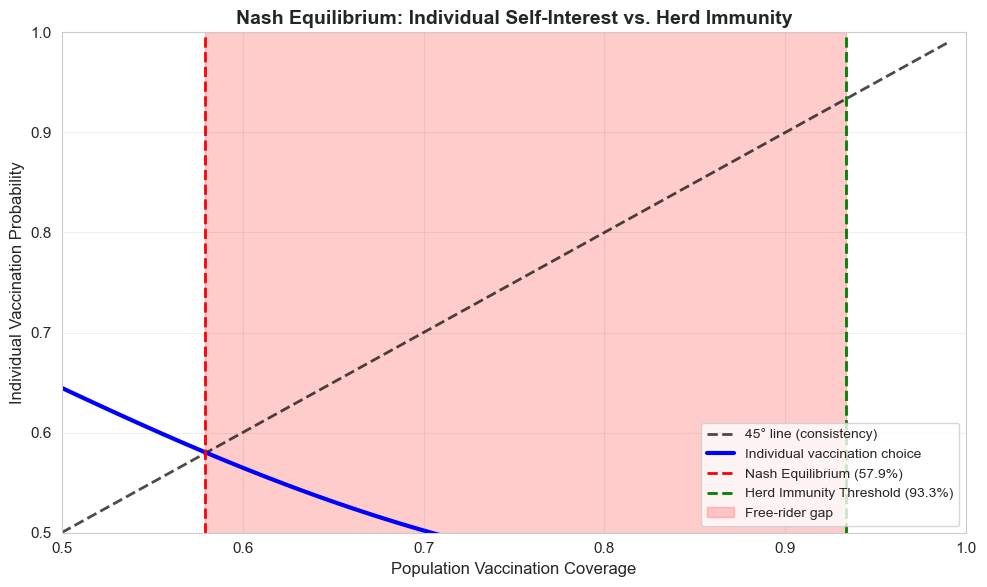

EQUILIBRIUM ANALYSIS:
Nash Equilibrium Coverage:       57.9%
Herd Immunity Threshold:         93.3%
Free-Rider Gap:                  35.4 percentage points

Conclusion: Self-interest leads to UNDER-vaccination
This is the classic free-rider problem in vaccination


In [60]:
# simple equilibrium visualization
# I'll do a full equilibrium analysis after integrating with SEIR model

# assume prevalence ≈ (1 - coverage) × base_prevalence
def simple_prevalence(coverage, base_prev=0.05):
    """Simplified prevalence as function of coverage."""
    # below HIT: endemic; above HIT: elimination
    hit = 1 - 1/epi_params.R0
    if coverage >= hit:     # Disease eliminated
        return 0.0  
    else:   # linear approximation        
        return base_prev * (1 - coverage/hit)

# calculate individual choice at different coverage levels
coverages = np.linspace(0.5, 0.99, 100)
individual_choices = []

for cov in coverages:
    prev = simple_prevalence(cov)
    prob = decision_model.vaccination_probability(prev, cov, epi_params.R0)
    individual_choices.append(prob)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(coverages, coverages, 'k--', linewidth=2, label='45° line (consistency)', alpha=0.7)    # 45-degree line: where population coverage = individual choice

# individual choice
ax.plot(coverages, individual_choices, linewidth=3, color='blue', 
        label='Individual vaccination choice')

# find approximate Nash equilibrium (where they cross)
differences = np.abs(np.array(individual_choices) - coverages)
nash_idx = np.argmin(differences)
nash_coverage = coverages[nash_idx]

# mark Nash and HIT
hit = 1 - 1/epi_params.R0
ax.axvline(x=nash_coverage, color='red', linestyle='--', linewidth=2, 
           label=f'Nash Equilibrium ({nash_coverage:.1%})')
ax.axvline(x=hit, color='green', linestyle='--', linewidth=2,
           label=f'Herd Immunity Threshold ({hit:.1%})')

ax.fill_betweenx([0, 1], nash_coverage, hit, alpha=0.2, color='red',
                  label='Free-rider gap')

ax.set_xlabel('Population Vaccination Coverage', fontsize=12)
ax.set_ylabel('Individual Vaccination Probability', fontsize=12)
ax.set_title('Nash Equilibrium: Individual Self-Interest vs. Herd Immunity', 
             fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(0.5, 1.0)
ax.set_ylim(0.5, 1.0)

plt.tight_layout()
plt.show()

print("EQUILIBRIUM ANALYSIS:")
print(f"Nash Equilibrium Coverage:       {nash_coverage:.1%}")
print(f"Herd Immunity Threshold:         {hit:.1%}")
print(f"Free-Rider Gap:                  {(hit - nash_coverage)*100:.1f} percentage points")
print(f"\nConclusion: Self-interest leads to UNDER-vaccination")
print(f"This is the classic free-rider problem in vaccination")

The above figure demonstrates the classic free-rider problem:
- **Individual Choice**: The solid blue line represents individual choice, and the downward slope of the line is the **"free-rider effect"**, meaning that when fewer people are vaccinated, there is a higher disease risk and a stronger individual incentive to vaccinate. When more people are vaccinated, however (heading right on the x-axis), herd immunity can protect the unvaccinated who can "free-ride" on others' immunity. 
- **Nash Equilibrium Crossing**: The point of crossing between the blue line, the red dashed line, and the consistency line represents an equlibrium point. Here 59.7% of the population is vaccinated, and individuals following a Nash equilibrium vaccinate at a rate of 57.9%. This is self-consistent behavior (no one wants to change). It *is* an equilibrium, but a suboptimal one. 
- **Free-Rider Gap**: The pink shaded area represents the 34.4% gap between the Nash equilibrium point (57.9%) and the HIT (93.3%). This gap between self-interest and societal is where policy intervention finds its opportunity. 

## Policy Interventions

How can we close the gap between Nash and HIT?

In [66]:
# test different policy interventions
interventions = {
    'Baseline (no intervention)': BehavioralParameters(),
    
    'Free vaccines (full subsidy)': BehavioralParameters(
        vaccine_subsidy=46.0  # free vaccine
    ),
    
    'Improved access': BehavioralParameters(
        convenience_factor=0.5  # half the barriers
    ),
    
    'Public health campaign': BehavioralParameters(
        risk_perception_bias=1.5,  # increase awareness of disease risk
        confidence=0.95  # improve confidence
    ),
    
    'Combined intervention': BehavioralParameters(
        vaccine_subsidy=46.0,
        convenience_factor=0.5,
        risk_perception_bias=1.5,
        confidence=0.95
    ),
}

# calculate Nash equilibrium for each
test_prev = 0.05
test_cov = 0.8

print(f"\n{'Intervention at 80% Coverage':<30} {'Vax Probability':<20}")
print("="*50)

for name, params in interventions.items():
    model = BehavioralDecisionModel(params)
    prob = model.vaccination_probability(test_prev, test_cov, epi_params.R0)
    print(f"{name:<30} {prob:.1%}")

print("\nCombined interventions most effective at raising coverage")


Intervention at 80% Coverage   Vax Probability     
Baseline (no intervention)     66.3%
Free vaccines (full subsidy)   75.0%
Improved access                70.9%
Public health campaign         76.3%
Combined intervention          83.0%

Combined interventions most effective at raising coverage
